In [128]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

#0 - rock
#1 - paper
#2 - scissors

In [129]:
%%writefile rock_agent.py
# Агент, который всегда выбирает "камень"

def rock_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'камень' (0).
    """
    return 0

Overwriting rock_agent.py


In [130]:
%%writefile paper_agent.py
# Агент, который всегда выбирает "бумагу"
def paper_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'бумагу' (1).
    """
    return 1

Overwriting paper_agent.py


In [131]:
%%writefile scissors_agent.py
# Агент, который всегда выбирает "ножницы"
def scissors_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'ножницы' (2).
    """
    return 2

Overwriting scissors_agent.py


In [132]:
%%writefile seq_agent.py
# Агент, который выбирает следующий элемент последовательности
def seq_agent(observation, configuration):
    """
    Агент, который выбирает следующий элемент последовательности.
    """
    # writing steps to local file
    with open('steps.txt', 'a') as file:
        file.write(f"{observation.step}\n")
    return observation.step % 3

Overwriting seq_agent.py


In [133]:
%%writefile reactionary_agent.py
# Агент, который реагирует на последние действия противника
import random
import math

def get_score(left_move, right_move):
    """
    Вычисляет результат последнего действия. 
    Возвращает 0 при ничьей, 1 при выигрыше и -1 при проигрыше.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def reactionary_agent(observation, configuration):
    """
    Агент реагирует на последние действия противника.
    Если предыдущий ход был проигран, выбирает новый ход.
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает следующий ход

    return last_react_action

Overwriting reactionary_agent.py


In [134]:
%%writefile counter_reactionary_agent.py
# Агент, который выбирает действие в зависимости от результатов последних ходов
import random
import math

last_counter_action = None
def get_score(left_move, right_move):
    """
    Возвращает счет на основе разницы между ходами.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def counter_reactionary_agent(observation, configuration):
    """
    Если агент выиграл, выбирает действие, чтобы противодействовать.
    Иначе адаптируется к ходу противника.
    """
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs  # если выиграл, выбирает контр-ход
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает ход противника + 1

    return last_counter_action

Overwriting counter_reactionary_agent.py


In [135]:
%%writefile copy_opponent_agent.py
# Агент, который копирует последний ход оппонента
import random
def copy_opponent_agent(observation, configuration):
    """
    Копирует последний ход противника. Если ход первый, выбирает случайно.
    """
    if observation.step > 0:
        return observation.lastOpponentAction  # копирует предыдущий ход противника
    else:
        return random.randrange(0, configuration.signs)  # случайный ход на первом шаге

Overwriting copy_opponent_agent.py


In [136]:
%%writefile nash_equilibrium_agent.py
# Агент по принципу равновесия Нэша (случайный выбор)
import random

def nash_equilibrium_agent(observation, configuration):
    """
    Случайный выбор действия для достижения равновесия Нэша.
    """
    return random.randint(0, 2)

Overwriting nash_equilibrium_agent.py


In [137]:
%%writefile rock_paper_agent.py
# Агент, который случайно выбирает между "камнем" и "бумагой"
import random

def rock_paper_agent(observation, configuration):
    """
    Случайно выбирает между 'камнем' (0) и 'бумагой' (1).
    """
    return random.randint(0, 1)

Overwriting rock_paper_agent.py


In [138]:
%%writefile paper_scissor_agent.py
# Агент, который случайно выбирает между "камнем" и "бумагой"
import random

def rock_paper_agent(observation, configuration):
    """
    Случайно выбирает между 'бумагой' (1) и 'ножницами' (2).
    """
    return random.randint(1, 2)

Overwriting paper_scissor_agent.py


In [139]:
%%writefile rock_scissor_agent.py
# Агент, который случайно выбирает между "камнем" и "ножницами"
import random

def rock_paper_agent(observation, configuration):
    """
    Случайно выбирает между 'камнем' (0) и 'ножницами' (2).
    """
    prob =  random.randint(0, 1)
    return 0 if prob == 0 else 2



Overwriting rock_scissor_agent.py


In [140]:
%%writefile statistical_agent.py
# Агент, который анализирует статистику ходов противника
import random
action_histogram = {}
def statistical_agent(observation, configuration):
    """
    Запоминает ходы противника и выбирает действие, чтобы противодействовать
    наиболее частому ходу противника.
    """
    global action_histogram
    if observation.step == 0:
        action_histogram = {}  # очищает историю в начале
        return random.randint(0, 2)  # случайный ход в начале
    
    action = observation.lastOpponentAction
    action_histogram[action] = action_histogram.get(action, 0) + 1  # считает ходы противника

    mode_action = max(action_histogram, key=action_histogram.get)  # находит наиболее частый ход
    return (mode_action + 1) % configuration.signs  # возвращает контр-ход

Overwriting statistical_agent.py


The winner is reactionary_agent.py !


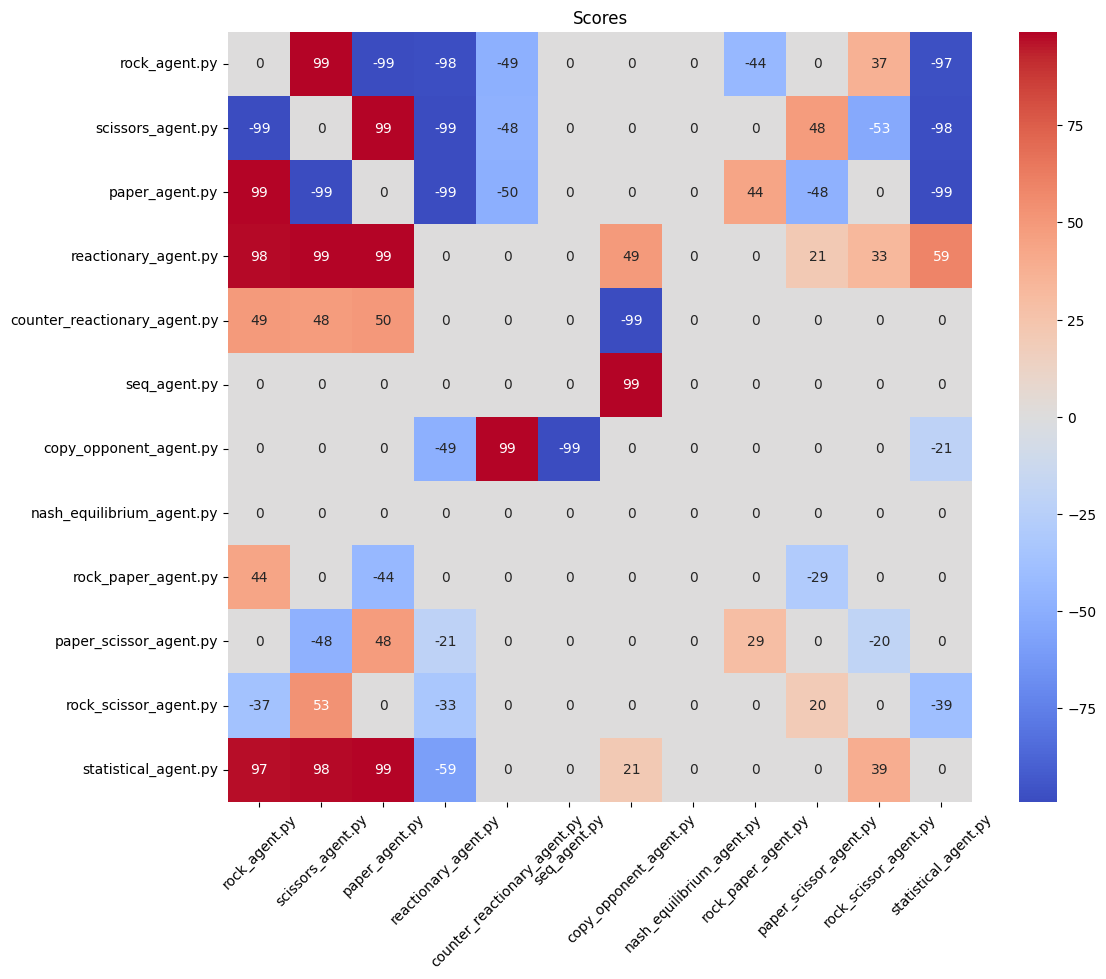

In [142]:
# Турнир между агентами
agents = [
    "rock_agent.py",
    "scissors_agent.py",
    "paper_agent.py",
    "reactionary_agent.py",
    "counter_reactionary_agent.py",
    "seq_agent.py",
    "copy_opponent_agent.py",
    "nash_equilibrium_agent.py",
    "rock_paper_agent.py",
    "paper_scissor_agent.py",
    "rock_scissor_agent.py",
    "statistical_agent.py",
]

# Берем длину списка агентов
n_agents = len(agents)

# Инициализируем матрицу результатов
scores = np.zeros((n_agents, n_agents))

# Играем каждый агент против каждого
for i in range(n_agents):
    for j in range(i + 1, n_agents):
        result = evaluate(
            "rps",
            [agents[i], agents[j]],
            configuration={"episodeSteps": 100},
            num_episodes=1,
        )
        scores[i][j] = result[0][0]  # сохраняем результат для агента i
        scores[j][i] = result[0][1]  # сохраняем результат для агента j

# Определяем победителя
vic = []
for i in range(n_agents):
    cnt_vic = sum(
        1 for j in range(n_agents) if scores[i][j] > 0
    )  # считаем победы агента
    vic.append(cnt_vic)

# Определяем индексы победителей
i_victors = [i for i, v in enumerate(vic) if v == max(vic)]
if len(i_victors) > 1:
    print("The winners are", "\n", *[agents[i] for i in i_victors], "!")
else:
    print("The winner is", agents[i_victors[0]], "!")

scores_df = pd.DataFrame(scores, columns=agents, index=agents)
plt.figure(figsize=(12, 10))
sns.heatmap(scores_df, annot=True, cmap="coolwarm", fmt=".0f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Scores")
plt.show()

In [126]:
evaluate(
    "rps", #environment to use - no need to change
    ["seq_agent.py", "nash_equilibrium_agent.py"], #agents to evaluate
    configuration={"episodeSteps": 1000} #number of episodes 
)

[[-21.0, 21.0]]

In [57]:
evaluate(
    "rps", #environment to use - no need to change
    ["nash_equilibrium_agent.py", "rock_agent.py"], #agents to evaluate
    configuration={"episodeSteps": 1000} #number of episodes 
)

[[-25.0, 25.0]]